<a href="https://colab.research.google.com/github/GallardoCarmen/APRENDIZAJE_AUTOMATICO_23_24/blob/main/P2Grupo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AA_PRACTICA3_GRUPO_NºA01
Carmen Gallardo, Marta Herraiz y Pablo Mendieta

# **1.- DEFINICIÓN DEL PROBLEMA**

El problema que nos enfrentamos es una clasificación de imágenes utilizando un modelo de Red Neuronal Convolucional (CNN). Utilizaremos el conjunto de datos CIFAR-100, que consta de imágenes en color de 32x32 píxeles, distribuidas en 100 clases y agrupadas en 20 superclases. Cada imagen tiene una etiqueta "fina" que representa la clase específica y una etiqueta "gruesa" que indica la superclase a la que pertenece. la información sobre esta base de datos se ha obtenido de  https://www.cs.toronto.edu/~kriz/cifar.html

Descripción del Conjunto de Datos CIFAR-100:

* **Número de Clases:** 100
* **Número de Superclases:** 20
* **Número de Imágenes por Clase:** 600
* **División de Conjuntos de Entrenamiento y Prueba por Clase:**

  500 imágenes de entrenamiento por clase.

  100 imágenes de prueba por clase.

OBJETIVO:
El objetivo es predecir a qué superclase y clase pertecenecen las imágenes del conjunto de test. Por lo que nos estamos enfrentando a un problema de **clasificación multiclase y una etiqueta**.

**Librerias necesarias para el modelo:**

In [1]:
# Importar la versión 2.x de TensorFlow
%tensorflow_version 2.x

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras

# NumPy para manipulación de matrices
import numpy as np

# pyplot de Matplotlib para visualización
import matplotlib.pyplot as plt
print(tf.__version__)

# clases específicas de Keras para construir el modelo
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Importar utilidades de Keras para codificación one-hot
from keras.utils import to_categorical

# conjunto de datos CIFAR-100 de Keras
from keras.datasets import cifar100

# OpenCV para manipulación de imágenes
import cv2

# capa de Dropout de Keras para regularización
from keras.layers import Dropout

# funciones específicas de procesamiento de imágenes de SciPy y skimage
from scipy.ndimage import convolve
from skimage import exposure, filters

# generador de imágenes de Keras para aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle

from scipy.ndimage import zoom

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.14.0


Funciones usadas:

In [2]:
def obtener_clase(etiqueta):
    clases = [
    "beaver", "dolphin", "otter", "seal", "whale",
    "aquarium fish", "flatfish", "ray", "shark", "trout",
    "orchids", "poppies", "roses", "sunflowers", "tulips",
    "bottles", "bowls", "cans", "cups", "plates",
    "apples", "mushrooms", "oranges", "pears", "sweet peppers",
    "clock", "computer keyboard", "lamp", "telephone", "television",
    "bed", "chair", "couch", "table", "wardrobe",
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",
    "bear", "leopard", "lion", "tiger", "wolf",
    "bridge", "castle", "house", "road", "skyscraper",
    "cloud", "forest", "mountain", "plain", "sea",
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
    "fox", "porcupine", "possum", "raccoon", "skunk",
    "crab", "lobster", "snail", "spider", "worm",
    "baby", "boy", "girl", "man", "woman",
    "crocodile", "dinosaur", "lizard", "snake", "turtle",
    "hamster", "mouse", "rabbit", "shrew", "squirrel",
    "maple", "oak", "palm", "pine", "willow",
    "bicycle", "bus", "motorcycle", "pickup truck", "train",
    "lawn-mower", "rocket", "streetcar", "tank", "tractor"
    ]

    clases.sort()
    indice_clase = etiqueta.argmax()

    return clases[indice_clase]

def obtener_superclase(etiqueta):
    superclase = ["aquatic mammals", "fish", "flowers", "food containers", "fruit and vegetables",
                  "household electrical devices", "household furniture", "insects", "large carnivores",
                  "large man-made outdoor things", "large natural outdoor scenes", "large omnivores and herbivores",
                  "medium-sized mammals", "non-insect invertebrates", "people", "reptiles", "small mammals",
                  "trees", "vehicles 1", "vehicles 2"]


    indice_supclase = etiqueta.argmax()
    return superclase [indice_supclase]

#Esta función obtiene la super clase a partir de la clase
def obtener_superclase_Desde_Clase(clase):
    clases_organizadas = {
        'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
        'fish': ['aquarium fish', 'flatfish', 'ray', 'shark', 'trout'],
        'flowers': ['orchids', 'poppies', 'roses', 'sunflowers', 'tulips'],
        'food containers': ['bottles', 'bowls', 'cans', 'cups', 'plates'],
        'fruit and vegetables': ['apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers'],
        'household electrical devices': ['clock', 'computer keyboard', 'lamp', 'telephone', 'television'],
        'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
        'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
        'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
        'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
        'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
        'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
        'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
        'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
        'people': ['baby', 'boy', 'girl', 'man', 'woman'],
        'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
        'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
        'trees': ['maple', 'oak', 'palm', 'pine', 'willow'],
        'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup truck', 'train'],
        'vehicles 2': ['lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
    }

    for superclase, clases in clases_organizadas.items():
        if clase in clases:
            return superclase

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)



# **2.- MEDIDA DE ÉXITO**

Buscamos que nuestro modelo tenga la mayor precisión posible a la hora de clasificar las imágenes. Podemos considerar que si el modelo proporciona una precisión mayor al 1% se podría considerar éxito, debido a que tenemos 100 tipos de clases diferentes y sería más eficiente que hacerlo al azar.

Primero vamos a comprobar la distribución de las clases para asegurarnos que están **equilibradas:**

169001437/169001437 [==============================] - 3s 0us/step


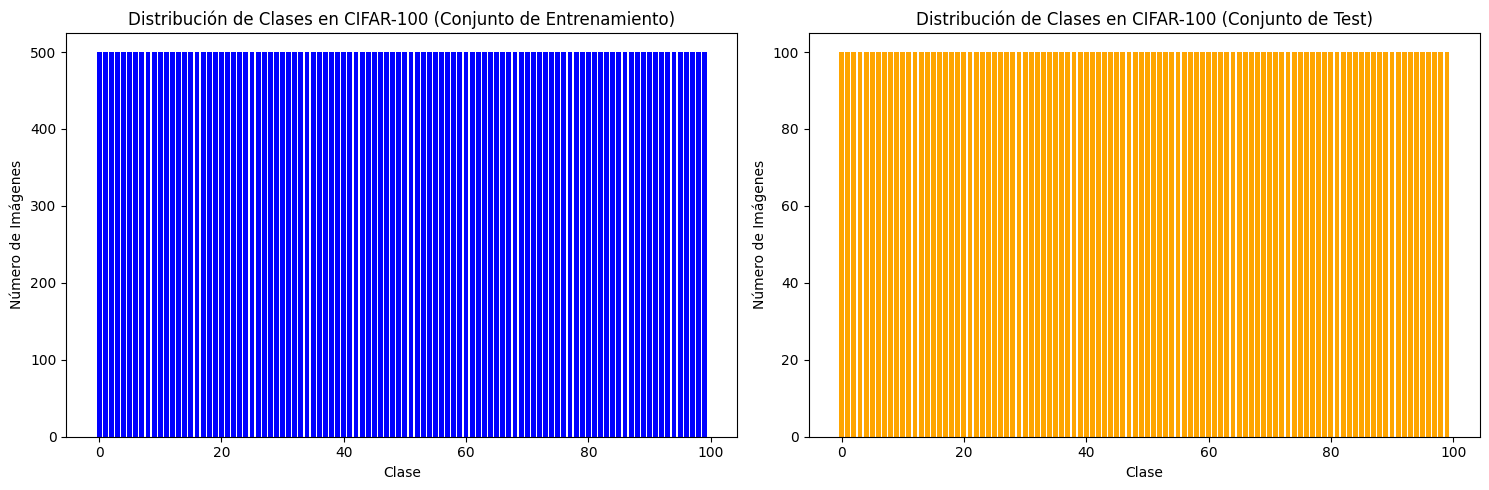

In [ ]:
# Cargar y dividir el conjunto de datos CIFAR-100
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Convertir las etiquetas de entrenamiento a una matriz unidimensional
train_labels_flat = train_labels.flatten()
class_counts_train = Counter(train_labels_flat)

# Convertir las etiquetas de prueba a una matriz unidimensional
test_labels_flat = test_labels.flatten()

class_counts_test = Counter(test_labels_flat)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica para el conjunto de entrenamiento
axs[0].bar(class_counts_train.keys(), class_counts_train.values(), color='blue')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Número de Imágenes')
axs[0].set_title('Distribución de Clases en CIFAR-100 (Conjunto de Entrenamiento)')

# Gráfica para el conjunto de prueba
axs[1].bar(class_counts_test.keys(), class_counts_test.values(), color='orange')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Número de Imágenes')
axs[1].set_title('Distribución de Clases en CIFAR-100 (Conjunto de Test)')

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
plt.show()

Podemos observar que las clases están equilibradas. Gracias a esto, nos aseguramos de evitar sesgos en el entrenamiento.





# **3.- DECISIÓN DE UN PROTOCOLO DE EVALUACIÓN**



Para medir el progreso acutal, el proceso de evaluación que elegimos va a ser **contar un conjunto de validación hold-out**, debido que tenemos un conjunto con muchos datos.

Para ello, dividiremos los datos de entrenamiento en dos conjuntos:

*   Datos de entrenamiento: 40.000 datos
*   Datos de validación: 10.000 datos

# **4.- PREPARACIÓN DE LOS DATOS**



### Trasformaciones fundamentales
Tenemos que dar los datos al modelo en formato adecuado.

*   Formatear los datos como **tensores**.
*   **Normalizar** los valores : [ 0, 1 ]
*   Generar más **imágenes**. (apartado 7)
*   Hacer **shuffle** con las imágenes
*   Hacer **ingeniería de Características**.

Lo primero que vamos a hacer es cargar los todos datos, incluyendo las etiquetas, tanto las de la categoría fina como las de la gruesa. Por otro lado, observamos la forma de los tensores de los datos.

In [3]:
#obtenicon de los datos
(train_images, train_labels_fine), (test_images, test_labels_fine) = cifar100.load_data(label_mode='fine')
(_, train_labels_coarse), (_, test_labels_coarse) = cifar100.load_data(label_mode='coarse')

print ("tamaño imagenes entrenamiento: ", train_images.shape)
print ("tamaño etiquetas entrenamiento finas: ", train_labels_fine.shape)
print ("tamaño etiquetas entrenamiento gruesas: ", train_labels_coarse.shape)
print ("tamaño imagenes test: ",test_images.shape)
print ("tamaño etiquetas test finas: ", test_labels_fine.shape)
print ("tamaño etiquetas test gruesas: ", test_labels_coarse.shape)

tamaño imagenes entrenamiento:  (50000, 32, 32, 3)
tamaño etiquetas entrenamiento finas:  (50000, 1)
tamaño etiquetas entrenamiento gruesas:  (50000, 1)
tamaño imagenes test:  (10000, 32, 32, 3)
tamaño etiquetas test finas:  (10000, 1)
tamaño etiquetas test gruesas:  (10000, 1)


Una vez obtenidos los datos, pasamos a observar una de las imagenes para hacernos a la idea de que tipo de imagenes son. Como hemos visto con la función "shape", las imagenes son de 32x32 pixeles y en color.

Por otro lado, vamos a normalizar las imagenes para escalar los valores de los pixeles entre 0 y 1 en vez de 0 y 255 y así acotar el rango. A su vez, vamos a pasar todas las etiquetas a categóricas para poder utilizar el optimizador categorical_crossentropy.

In [4]:
#Normalizacion
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

#etiquetas a categóricas
train_labels_fine = to_categorical(train_labels_fine)
test_labels_fine = to_categorical(test_labels_fine)
train_labels_coarse = to_categorical(train_labels_coarse)
test_labels_coarse = to_categorical(test_labels_coarse)

print ("tamaño etiquetas entrenamiento finas: ", train_labels_fine.shape)
print ("tamaño etiquetas entrenamiento gruesas: ", train_labels_coarse.shape)
print ("tamaño etiquetas test finas: ", test_labels_fine.shape)
print ("tamaño etiquetas test gruesas: ", test_labels_coarse.shape)


tamaño etiquetas entrenamiento finas:  (50000, 100)
tamaño etiquetas entrenamiento gruesas:  (50000, 20)
tamaño etiquetas test finas:  (10000, 100)
tamaño etiquetas test gruesas:  (10000, 20)


Vamos a ver como ejemplo una de las imagenes con sus respectivas etiquetas(estamos utilizando las funciones definidas en el primer apartado):

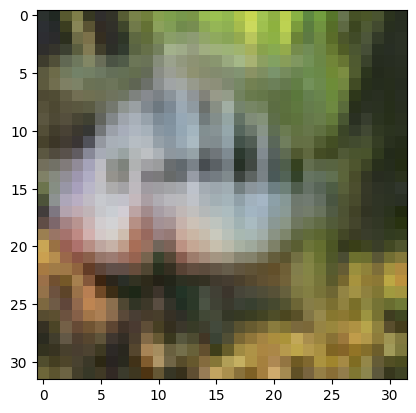

Clase:  aquarium fish
Superclase:  fish


In [5]:
#Ejemplo
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()
print("Clase: ", obtener_clase(train_labels_fine[4]))
print("Superclase: ", obtener_superclase(train_labels_coarse[4]))

### **MEZCLAR LAS IMÁGENES**

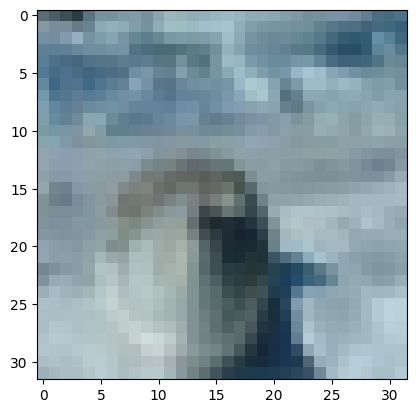

Clase:  seal
Superclase:  aquatic mammals


In [6]:
#Barajar los datos de entrenamiento
train_images, train_labels_fine, train_labels_coarse = shuffle(train_images, train_labels_fine, train_labels_coarse, random_state=42)

# Barajar los datos de prueba
test_images, test_labels_fine, test_labels_coarse = shuffle(test_images, test_labels_fine, test_labels_coarse, random_state=42)

# Visualizar una imagen después de barajar
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()
print("Clase: ", obtener_clase(train_labels_fine[4]))
print("Superclase: ", obtener_superclase(train_labels_coarse[4]))


**APARTADO 3:**

dividir los datos de entrenamiento en dos conjuntos:

*   Datos de entrenamiento: 40.000 datos
*   Datos de validación: 10.000 datos


In [7]:
train_images_validation = train_images[10000:]
partial_train_images_validation = train_images[:10000]

train_labels_fine_validation = train_labels_fine[10000:]
partial_train_labels_fine_validation = train_labels_fine[:10000]

train_labels_coarse_validation = train_labels_coarse[10000:]
partial_train_labels_coarse_validation = train_labels_coarse[:10000]

print("Número de imágenes de entrenamiento:", len(train_images_validation))
print("Número de imágenes de validación:", len(partial_train_images_validation))


Número de imágenes de entrenamiento: 40000
Número de imágenes de validación: 10000


### **INGENIERÍA DE CARACTERÍSTICA**
Vamos a tratar de aplicar filtros a las imagenes para intentar encontrar algún cambio que mejore las imagenes, ya que al tener muy baja resolución va a ser muy complicado que obtengamos valores de accuracy decentes.Para ello, vamos a aplicar varios kernels.

#### **Afilar imágenes:**

Usamos un kernel para afilar las imágenes y conseguir que los bordes estén más detallados.


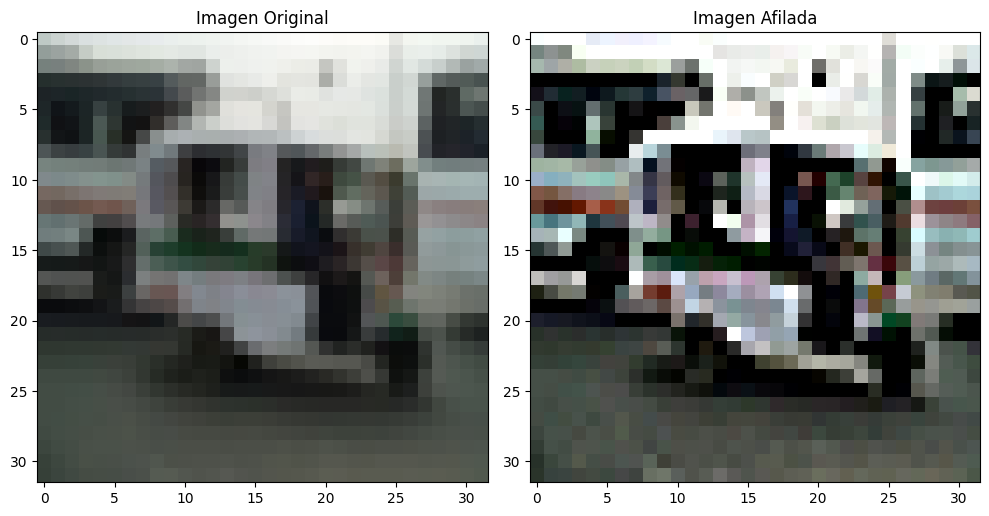

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
kernel_afilado = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]], dtype=np.float32)

# Seleccionar una imagen de tu conjunto de datos
imagen_original = train_images[1]

# Aplicar el filtro de afilado utilizando filter2D
imagen_afilada = cv2.filter2D(imagen_original, -1, kernel_afilado)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar la imagen original
axes[0].imshow(imagen_original, cmap=plt.cm.binary)
axes[0].set_title('Imagen Original')

# Mostrar la imagen afilada
axes[1].imshow(imagen_afilada, cmap=plt.cm.binary)
axes[1].set_title('Imagen Afilada')
plt.tight_layout()

plt.show()

#TODAS LAS IMAGENES
train_images_afiladas = []
test_images_afiladas = []

for imagen_original in train_images:

    imagen_procesada = cv2.filter2D(imagen_original, -1, kernel_afilado)
    train_images_afiladas.append(imagen_procesada)

for imagen_original in test_images:

    imagen_procesada = cv2.filter2D(imagen_original, -1, kernel_afilado)
    test_images_afiladas.append(imagen_procesada)

train_images_afiladas = np.array(train_images_afiladas)
test_images_afiladas = np.array(test_images_afiladas)

#comprobamos que el tamaño sigue siendo el mismo
print (train_images_afiladas.shape)
print (test_images_afiladas.shape)

Se observa que las imagenes afiladas remarcan más los bordes de la figura, lo que puede ser una buena opción para que el modelo reconozca mejor ciertas características.

#### **Filtro Laplace:**
También vamos a tratar de usar el filtro de Laplace, ya que es bastante usado para el reconocimiento de bordes, ya que las realza. La información sobre este filtro se ha obtenido de la siguiente página: https://pythoneyes.wordpress.com/2017/06/20/filtro-de-laplace-realce-de-bordes-en-imagenes-con-python-3/


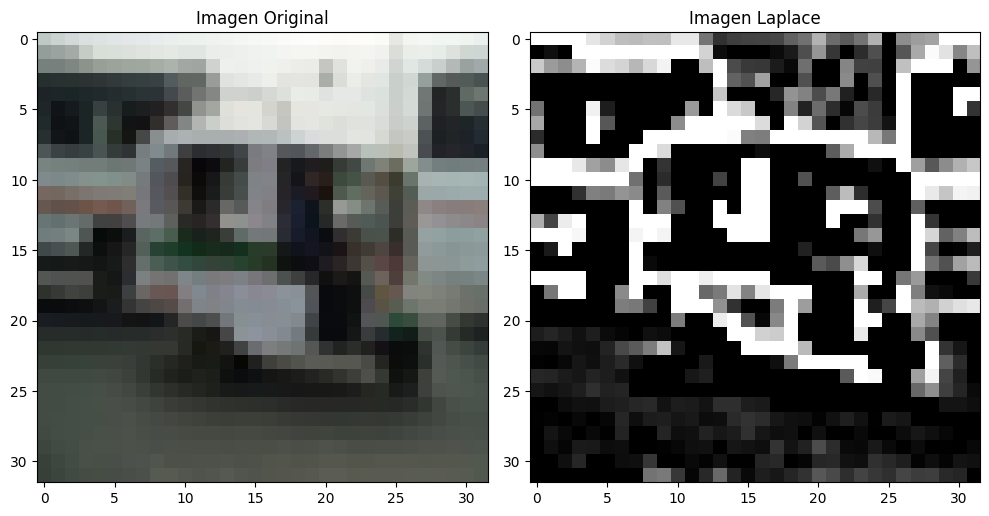

In [9]:
# Definir el tamaño del kernel y los coeficientes
tamaño = (5, 5)
coeficientes = np.array([0, 0, -1, 0, 0, 0, -1, -2, -1, 0, -1, -2, 16, -2, -1, 0, -1, -2, -1, 0, 0, 0, -1, 0, 0], dtype=np.float32)
coeficientes = coeficientes.reshape((tamaño[0], tamaño[1]))  # Reorganizar la lista en una matriz 2D
factor = 1


# Seleccionar una imagen de tu conjunto de datos
imagen_original = train_images[1]

# Aplicar el filtro de Laplace utilizando filter2D
imagen_original_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
imagen_lapl = cv2.filter2D(imagen_original_gris, -1, coeficientes * factor)
imagen_lapl = cv2.cvtColor(imagen_lapl, cv2.COLOR_GRAY2BGR)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar la imagen original
axes[0].imshow(imagen_original, cmap=plt.cm.binary)
axes[0].set_title('Imagen Original')

# Mostrar la imagen afilada
axes[1].imshow(imagen_lapl, cmap=plt.cm.binary)
axes[1].set_title('Imagen Laplace')
plt.tight_layout()

plt.show()

# Aplicar el filtro a todo el conjunto de imágenes
train_images_Lap = []

for imagen_original in train_images:
    # Convertir la imagen a escala de grises si es necesario
    if imagen_original.shape[-1] == 3:
        imagen_original_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    else:
        imagen_original_gris = imagen_original

    # Asegurarse de que la imagen original sea de tipo float32
    imagen_original_gris = imagen_original_gris.astype(np.float32)

    # Aplicar el filtro utilizando filter2D
    imagen_procesada_BYN = cv2.filter2D(imagen_original_gris, -1, coeficientes * factor)

    # Convertir la imagen procesada de nuevo a color si es necesario
    if imagen_original.shape[-1] == 3:
      imagen_bordes= cv2.cvtColor(imagen_procesada_BYN, cv2.COLOR_GRAY2BGR)

    # Agregar la imagen procesada a la lista
    train_images_Lap.append(imagen_bordes)

# Convertir la lista a un tensor numpy
train_images_Lap = np.array(train_images_Lap)



# Aplicar el filtro a todo el conjunto de imágenes
test_images_Lap = []

for imagen_original in test_images:
    # Convertir la imagen a escala de grises si es necesario
    if imagen_original.shape[-1] == 3:
        imagen_original_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    else:
        imagen_original_gris = imagen_original

    # Asegurarse de que la imagen original sea de tipo float32
    imagen_original_gris = imagen_original_gris.astype(np.float32)

    # Aplicar el filtro utilizando filter2D
    imagen_procesada_BYN = cv2.filter2D(imagen_original_gris, -1, coeficientes * factor)

    # Convertir la imagen procesada de nuevo a color si es necesario
    if imagen_original.shape[-1] == 3:
      imagen_bordes = cv2.cvtColor(imagen_procesada_BYN, cv2.COLOR_GRAY2BGR)

    # Agregar la imagen procesada a la lista
    test_images_Lap.append(imagen_bordes)

# Convertir la lista a un tensor numpy
test_images_Lap = np.array(test_images_Lap)


### Aumentar el tamaño de las imagenes (Interpolación)


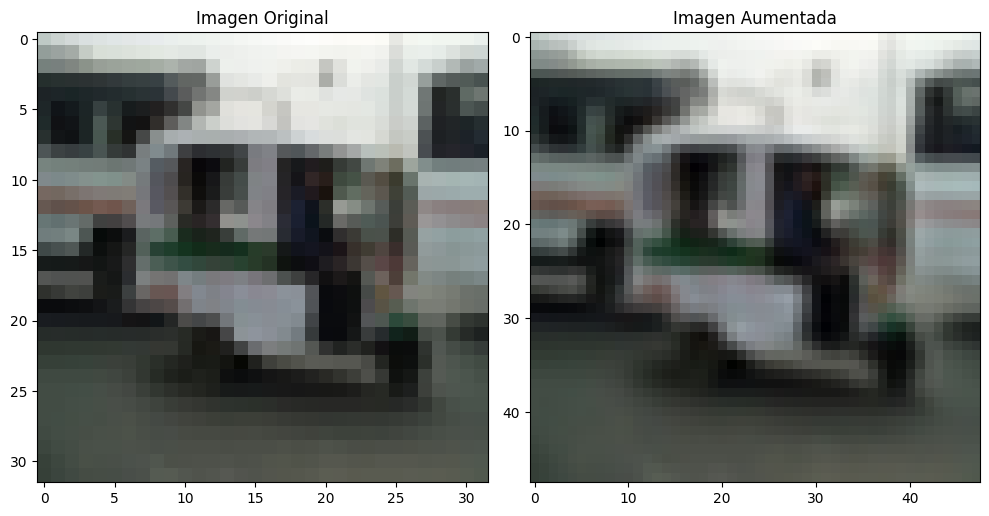

In [10]:
scale_factor = 1.5

# Lista para almacenar las imágenes aumentadas
train_images_aumentadas = []

# Iterar sobre cada imagen en el conjunto de datos original
for img in train_images:
    # Aplicar la interpolación para aumentar el tamaño
    img_resized = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # Añadir la imagen aumentada a la lista
    train_images_aumentadas.append(img_resized)

# Convertir la lista de imágenes aumentadas a un tensor
train_images_aumentadas = np.array(train_images_aumentadas)


# Lista para almacenar las imágenes aumentadas
test_images_aumentadas = []

# Iterar sobre cada imagen en el conjunto de datos original
for img in test_images:
    # Aplicar la interpolación para aumentar el tamaño
    img_resized = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # Añadir la imagen aumentada a la lista
    test_images_aumentadas.append(img_resized)

# Convertir la lista de imágenes aumentadas a un tensor
test_images_aumentadas = np.array(test_images_aumentadas)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar la imagen original
axes[0].imshow(train_images[1], cmap=plt.cm.binary)
axes[0].set_title('Imagen Original')

# Mostrar la imagen afilada
axes[1].imshow(train_images_aumentadas[1], cmap=plt.cm.binary)
axes[1].set_title('Imagen Aumentada')
plt.tight_layout()


Hemos pasado de tener imagenes de 32x32 pixeles a 48x48, las cuales son claramente de mayor calidad, el problema es que aumentar las imagenes consume una gran cantidad de RAM, por lo que una vez las probemos, tendremos que analizar si merece la pena tanto consumo de recursos a cambio de un poco de mejora en la accuracy.

# **5.- DESARROLLO DE MODELOS MEJOR QUE EL DE REFERENCIA**



Necesitamos un modelo que acierte por lo menos un 1% de los casos, ya que tenemos 100 categorías diferentes, por lo que aleatoriamente ya se podría obtener ese 1%.

### **MODELO DE REFRENCIA**

Las capas fundamentales para poder realizar un modelo convolucional son las siguientes.

*   1 capa convolucional
*   1 capa de Max Pooling
*   1 capa flatten
*   2 capas Densas de salida
Nota: utilizamos dos salidas para poder obtener la clase fina y la gruesa.


In [ ]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))(input_layer)
pol = MaxPooling2D(pool_size=(2, 2)) (conv)

flat = Flatten() (pol)

output_fine = Dense(100, activation='softmax', name='output_fine') (flat)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (flat)
model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='sgd',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

model.fit(train_images, {'output_fine': train_labels_fine, 'output_coarse': train_labels_coarse},
          epochs = 15,
          batch_size = 64,
          verbose = 1)

score = model.evaluate(test_images, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

Epoch 1/15
782/782 [==============================] - 89s 113ms/step - loss: 7.0507 - output_fine_loss: 4.3387 - output_coarse_loss: 2.7121 - output_fine_accuracy: 0.0559 - output_coarse_accuracy: 0.1670
Epoch 2/15
782/782 [==============================] - 87s 111ms/step - loss: 6.3940 - output_fine_loss: 3.8982 - output_coarse_loss: 2.4958 - output_fine_accuracy: 0.1232 - output_coarse_accuracy: 0.2342
Epoch 3/15
782/782 [==============================] - 82s 105ms/step - loss: 6.1128 - output_fine_loss: 3.7091 - output_coarse_loss: 2.4037 - output_fine_accuracy: 0.1609 - output_coarse_accuracy: 0.2652
Epoch 4/15
782/782 [==============================] - 83s 106ms/step - loss: 5.9055 - output_fine_loss: 3.5824 - output_coarse_loss: 2.3230 - output_fine_accuracy: 0.1829 - output_coarse_accuracy: 0.2933
Epoch 5/15
782/782 [==============================] - 83s 106ms/step - loss: 5.7194 - output_fine_loss: 3.4731 - output_coarse_loss: 2.2463 - output_fine_accuracy: 0.2034 - output_coar

### **PRECISIÓN APROXIMADA** = 30.51 %

A partir de la precisión del modelo de referencia empezaremos a trabajar. Todos los modelos que devueleva una precisión inferior al **30.5%** los descartamos directamente. Es importante destacar que la precisión en las clases gruesas es mayor (como era de esperar, por el número de clases que hay)

### **MODELO CON LAS IMÁGENES AFILADAS:**
*   1 Capa Convolucional
*   1 capa de Max Pooling
*   1 capa Flatten
*   2 capas Densas de salida



In [ ]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))(input_layer)
pol = MaxPooling2D(pool_size=(2, 2)) (conv)

flat = Flatten() (pol)

output_fine = Dense(100, activation='softmax', name='output_fine') (flat)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (flat)
model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='sgd',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

model.fit(train_images_afiladas, {'output_fine': train_labels_fine, 'output_coarse': train_labels_coarse},
          epochs = 15,
          batch_size = 64,
          verbose = 1)

score = model.evaluate(test_images_afiladas, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

Epoch 1/15
782/782 [==============================] - 107s 135ms/step - loss: 6.9620 - output_fine_loss: 4.3025 - output_coarse_loss: 2.6595 - output_fine_accuracy: 0.0665 - output_coarse_accuracy: 0.1936
Epoch 2/15
782/782 [==============================] - 87s 111ms/step - loss: 6.0248 - output_fine_loss: 3.7051 - output_coarse_loss: 2.3197 - output_fine_accuracy: 0.1650 - output_coarse_accuracy: 0.2978
Epoch 3/15
782/782 [==============================] - 85s 108ms/step - loss: 5.4637 - output_fine_loss: 3.3393 - output_coarse_loss: 2.1243 - output_fine_accuracy: 0.2353 - output_coarse_accuracy: 0.3561
Epoch 4/15
782/782 [==============================] - 84s 107ms/step - loss: 5.0366 - output_fine_loss: 3.0519 - output_coarse_loss: 1.9847 - output_fine_accuracy: 0.2889 - output_coarse_accuracy: 0.4026
Epoch 5/15
782/782 [==============================] - 83s 106ms/step - loss: 4.7043 - output_fine_loss: 2.8249 - output_coarse_loss: 1.8793 - output_fine_accuracy: 0.3323 - output_coa

### **precisión aproximada** = *32.28* %
Las imágenes afiladas funcionan mejor que las imágeness originales.

### **MODELO CON LAS IMÁGENES CON BORDES RESALTADOS (LAPLACE):**





In [ ]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))(input_layer)
pol = MaxPooling2D(pool_size=(2, 2)) (conv)

flat = Flatten() (pol)

output_fine = Dense(100, activation='softmax', name='output_fine') (flat)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (flat)
model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='sgd',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

model.fit(train_images_Lap, {'output_fine': train_labels_fine, 'output_coarse': train_labels_coarse},
          epochs = 15,
          batch_size = 64,
          verbose = 1)

score = model.evaluate(test_images_Lap, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

Epoch 1/15
782/782 [==============================] - 83s 104ms/step - loss: 7.0423 - output_fine_loss: 4.3240 - output_coarse_loss: 2.7182 - output_fine_accuracy: 0.0727 - output_coarse_accuracy: 0.1868
Epoch 2/15
782/782 [==============================] - 83s 107ms/step - loss: 6.0539 - output_fine_loss: 3.6844 - output_coarse_loss: 2.3696 - output_fine_accuracy: 0.1845 - output_coarse_accuracy: 0.3022
Epoch 3/15
782/782 [==============================] - 81s 103ms/step - loss: 5.5123 - output_fine_loss: 3.2570 - output_coarse_loss: 2.2553 - output_fine_accuracy: 0.2586 - output_coarse_accuracy: 0.3346
Epoch 4/15
782/782 [==============================] - 83s 106ms/step - loss: 5.1455 - output_fine_loss: 2.9711 - output_coarse_loss: 2.1744 - output_fine_accuracy: 0.3127 - output_coarse_accuracy: 0.3608
Epoch 5/15
782/782 [==============================] - 81s 103ms/step - loss: 4.8701 - output_fine_loss: 2.7563 - output_coarse_loss: 2.1137 - output_fine_accuracy: 0.3530 - output_coar

### **precisión aproximada** = *21.85* %

Las imágenes con Bordes Resaltados **no** son más eficientes que las imágenes orginales, por lo que no las usaremos.

### Modelo con las imagenes aumentadas:

Para este modelo hemos tenido que reducir el número de épocas y aumentar el bach-size, asi como eliminar la salida de la clase gruesa, porque consume demasiados recursos.



In [ ]:
input_layer = Input(shape=(48, 48, 3))

conv = Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 3))(input_layer)
pol = MaxPooling2D(pool_size=(2, 2)) (conv)

flat = Flatten() (pol)

dense = Dense(512, activation='relu') (flat)

output_fine = Dense(100, activation='softmax', name='output_fine') (dense)
model = Model(inputs=input_layer, outputs=output_fine)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_images_aumentadas, train_labels_fine,
          epochs = 15,
          batch_size = 200,
          verbose = 1)

score = model.evaluate(test_images_aumentadas, test_labels_fine )
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[1])


Epoch 1/15
250/250 [==============================] - 683s 3s/step - loss: 3.6980 - accuracy: 0.1559
Epoch 2/15
250/250 [==============================] - 698s 3s/step - loss: 2.8129 - accuracy: 0.3130
Epoch 3/15
250/250 [==============================] - 685s 3s/step - loss: 2.4083 - accuracy: 0.3935
Epoch 4/15
250/250 [==============================] - 697s 3s/step - loss: 2.0768 - accuracy: 0.4663
Epoch 5/15
250/250 [==============================] - 687s 3s/step - loss: 1.7519 - accuracy: 0.5423
Epoch 6/15
250/250 [==============================] - 714s 3s/step - loss: 1.4417 - accuracy: 0.6194
Epoch 7/15
250/250 [==============================] - 715s 3s/step - loss: 1.1321 - accuracy: 0.6995
Epoch 8/15
250/250 [==============================] - 711s 3s/step - loss: 0.8708 - accuracy: 0.7704
Epoch 9/15
250/250 [==============================] - 714s 3s/step - loss: 0.6468 - accuracy: 0.8329
Epoch 10/15
250/250 [==============================] - 711s 3s/step - loss: 0.4589 - accura

Llegamos a la conclusión de que la mejora no es lo suficientemente significativa como para utilizar estas imagenes, ya que no disponemos de los recursos necesarios. Si se hubiera podido, probablemente aumentar las imagenes a un tamaño 64x64 habría aumentado la accuracy.
Cabe destacar que el modelo se entrena más facilmente y es capaz de alcanzar una mayor precisión más rápido.

# **6.- DESARROLLO DE UN MODELO CON SOBREAJUSTE**


In [ ]:
# Configurar el callback EarlyStopping para detener el entrenamiento si la pérdida en val_loss no mejora durante 5 épocas consecutivas
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5)  # Si val_loss no disminuye durante 5 épocas consecutivas, se detiene el entrenamiento

### **MODELO MULTICAPA CON IMÁGENES AFILADAS:**


Vamos a aumentar el número de capas convolucionales para encontrar un modelo que sea capaz de obtener mucha más precisión. Las capas van a ser las siguientes:

*   2 Capas Convolucionales(32, (3,3))
*   1 Capa Max Pooling
*   2 Capas Convolucionales(64, (3,3))
*   1 Capa Max Pooling
*   2 Capas Convolucionales(128, (3,3))
*   1 Capa Max Pooling

Es importante mencionar que a este modelo se le podrían añadir muchas capas más y esto aumentaría la potencia, pero para ello se requieren unos recursos de los que no disponemos. Ya con este tipo de modelo nos podemos hacer una idea de como debe ser. Recordemos que después de una capa convolucional suele ser necesario una de pooling. También introducimos capas densas para aumentar el número de parametros.

https://www.kaggle.com/code/diaaessam/alexnet-for-cifar-100 en este proyecto podemos ver como se puede crear una buena arquitectura, más compleja. Las capas convolucionales permiten aprender jerarquías de características en una imagen. Capas más profundas pueden capturar patrones de mayor complejidad y abstracción, permitiendo que el modelo represente conceptos más sofisticados. https://github.com/Sripriya07/CIFAR-100/blob/master/cifar100.py en este otro proyecto también podemos como crear una arquitectura multicapa compleja.




Por otro lado, vamos a hacer la separación de los datos de entrenamiento en dos conjuntos, para utilizar la validación hold- out.

In [ ]:
train_images_validation = train_images_afiladas[10000:]
partial_train_images_validation = train_images_afiladas[:10000]

print(len(train_images_validation))
print(len(partial_train_images_validation))

train_labels_fine_validation = train_labels_fine[10000:]
partial_train_labels_fine_validation = train_labels_fine[:10000]

train_labels_coarse_validation = train_labels_coarse[10000:]
partial_train_labels_coarse_validation = train_labels_coarse[:10000]

40000
10000


Epoch 1/50
313/313 [==============================] - 392s 1s/step - loss: 6.6931 - output_fine_loss: 4.1064 - output_coarse_loss: 2.5867 - output_fine_accuracy: 0.0694 - output_coarse_accuracy: 0.1962 - val_loss: 5.9288 - val_output_fine_loss: 3.6583 - val_output_coarse_loss: 2.2705 - val_output_fine_accuracy: 0.1237 - val_output_coarse_accuracy: 0.3015
Epoch 2/50
313/313 [==============================] - 388s 1s/step - loss: 5.4172 - output_fine_loss: 3.3413 - output_coarse_loss: 2.0759 - output_fine_accuracy: 0.1835 - output_coarse_accuracy: 0.3505 - val_loss: 5.0883 - val_output_fine_loss: 3.1288 - val_output_coarse_loss: 1.9596 - val_output_fine_accuracy: 0.2196 - val_output_coarse_accuracy: 0.3847
Epoch 3/50
313/313 [==============================] - 416s 1s/step - loss: 4.5823 - output_fine_loss: 2.8320 - output_coarse_loss: 1.7503 - output_fine_accuracy: 0.2764 - output_coarse_accuracy: 0.4493 - val_loss: 4.3281 - val_output_fine_loss: 2.6773 - val_output_coarse_loss: 1.6508 -

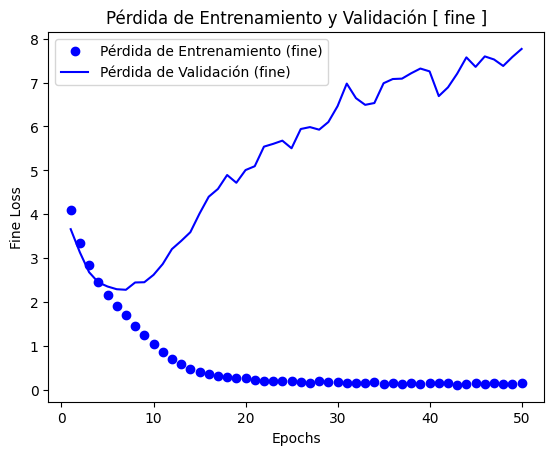

Valor máximo: 0.41679999232292175
Posición del valor máximo: 9
Valor máximo (entrenamiento): 0.965749979019165


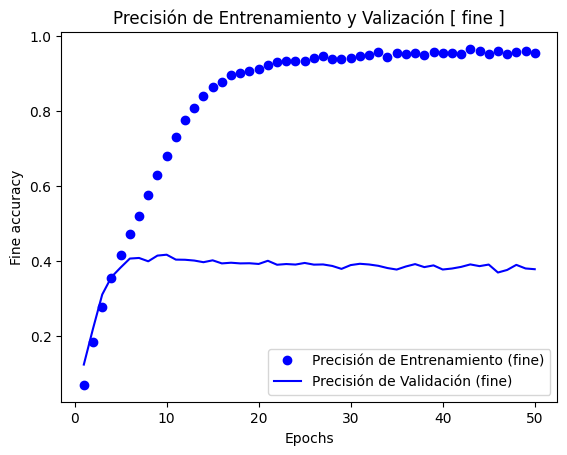

In [ ]:

input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3))(input_layer)
conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (conv)
pol = MaxPooling2D(pool_size=(2, 2)) (conv2)


conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (pol)
conv4 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (conv3)
pol2 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(pol2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (conv5)
pol3 = MaxPooling2D(pool_size=(2, 2)) (conv6)

flat = Flatten() (pol3)
dense = Dense(512, activation='relu') (flat)
dense1 = Dense(128, activation='relu') (dense)

output_fine = Dense(100, activation='softmax', name='output_fine') (dense1)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (dense1)

model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='Adam',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

history = model.fit(train_images_validation, {'output_fine': train_labels_fine_validation, 'output_coarse': train_labels_coarse_validation},
          epochs = 50,
          batch_size = 128,
          validation_data = (partial_train_images_validation, {'output_fine': partial_train_labels_fine_validation, 'output_coarse': partial_train_labels_coarse_validation}),
          verbose = 1)


score = model.evaluate(test_images_afiladas, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

# Graficamos la pérdida y la precisión.
history_dict = history.history
history_dict.keys()

output_fine_loss = history.history['output_fine_loss']
val_output_fine_loss = history.history['val_output_fine_loss']


epochs = range(1, len(output_fine_loss) + 1)

valor_minimo = min(val_output_fine_loss)
posicion_minimo = val_output_fine_loss.index(valor_minimo)
print("Valor mínimo:", valor_minimo)
print("Posición del valor mínimo:", posicion_minimo)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_loss, 'bo', label='Pérdida de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_loss, 'b', label='Pérdida de Validación (fine)')
plt.title('Pérdida de Entrenamiento y Validación [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine Loss')
plt.legend()

plt.show()

output_fine_accuracy = history.history['output_fine_accuracy']
val_output_fine_accuracy = history.history['val_output_fine_accuracy']

valor_maximo = max(val_output_fine_accuracy)
posicion_maximo = val_output_fine_accuracy.index(valor_maximo)
print("Valor máximo:", valor_maximo)
print("Posición del valor máximo:", posicion_maximo)

valor_maximo_entrenamiento = max(output_fine_accuracy)
posicion_maximo_entrenamiento = output_fine_accuracy.index(valor_maximo_entrenamiento)
print("Valor máximo (entrenamiento):", valor_maximo_entrenamiento)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_accuracy, 'bo', label='Precisión de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_accuracy, 'b', label='Precisión de Validación (fine)')
plt.title('Precisión de Entrenamiento y Valización [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine accuracy')
plt.legend()

plt.show()

### **precisión aproximada** = 40 %

Observamos que se alcanza una precisión mucho más elevada que el modelo básico, pero está bastante sobreentrenado, ya que estamos realizando 50 épocas.

# **7.- REGULACIÓN DEL MODELO Y AJUSTE DE HIPERPARÁMETROS**


### TEORIA


Para regular el modelo y conseguir el mínimo error con el máximo *accuracy* usaremos diferentes técnicas de regulación:
*   **Dropout:**

La capa Dropout establece aleatoriamente las unidades de entrada en 0 con una frecuencia de en cada paso durante el tiempo de entrenamiento, lo que ayuda a evitar el sobreajuste. Las entradas que no se establecen en 0 se escalan verticalmente en 1/(1 - tasa) de modo que la suma de Todas las entradas no cambian

*   **Batch Normalization:**

La normalización por lotes aplica una transformación que mantiene la salida media cerca de 0 y la desviación estándar de salida cercana a 1.

*   **L1 y L2**

En la regularización **L1**, se agrega a la función de pérdida la suma de los valores absolutos de los pesos multiplicados por un factor de regularización (
λ).Tiene la propiedad de inducir sparsity, es decir, algunos pesos pueden volverse exactamente cero, lo que puede llevar a una selección de características automática.


En la regularización **L2**, se agrega a la función de pérdida la suma de los cuadrados de los valores de los pesos multiplicados por un factor de regularización (λ). Penaliza los pesos grandes pero no induce sparsity, ya que todos los pesos contribuyen a la pérdida.

*  **Learning back decay**


La función callback ReduceLROnPlateau en Keras se utiliza para ajustar automáticamente la tasa de aprendizaje durante el entrenamiento del modelo. Su propósito es reducir la tasa de aprendizaje cuando ciertas condiciones se cumplen, lo que puede ayudar a mejorar la convergencia del modelo.

Para nuestro modelo final vamos a utilizar el Learning back decay, las capas de dropout y las capas de bacht Normalization.


In [ ]:

# Crear el callback ReduceLROnPlateau para ajustar la tasa de aprendizaje
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_output_fine_accuracy",
                                                 factor=0.2,  # Multiplicar la tasa de aprendizaje por 0.2 (reducir en 5 veces)
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)
# Configurar el callback EarlyStopping para detener el entrenamiento si la pérdida en val_loss no mejora durante 5 épocas consecutivas
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_output_fine_accuracy",
                                                  patience=5)  # Si val_loss no disminuye durante 5 épocas consecutivas, se detiene el entrenamiento

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_output_fine_accuracy")

40000
10000


### **MODELO FINAL + mejora de añadir imagenes**

Epoch 1/100
1563/1563 [==============================] - 39s 14ms/step - loss: 5.7220 - output_fine_loss: 3.4907 - output_coarse_loss: 2.2313 - output_fine_accuracy: 0.1706 - output_coarse_accuracy: 0.3213 - val_loss: 4.7202 - val_output_fine_loss: 2.8625 - val_output_coarse_loss: 1.8578 - val_output_fine_accuracy: 0.2752 - val_output_coarse_accuracy: 0.4168 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 22s 14ms/step - loss: 4.3052 - output_fine_loss: 2.6320 - output_coarse_loss: 1.6732 - output_fine_accuracy: 0.3212 - output_coarse_accuracy: 0.4734 - val_loss: 3.7678 - val_output_fine_loss: 2.3237 - val_output_coarse_loss: 1.4441 - val_output_fine_accuracy: 0.3768 - val_output_coarse_accuracy: 0.5348 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 21s 14ms/step - loss: 3.7688 - output_fine_loss: 2.3149 - output_coarse_loss: 1.4538 - output_fine_accuracy: 0.3809 - output_coarse_accuracy: 0.5365 - val_loss: 3.6771 - val_output_fine_loss: 2.2

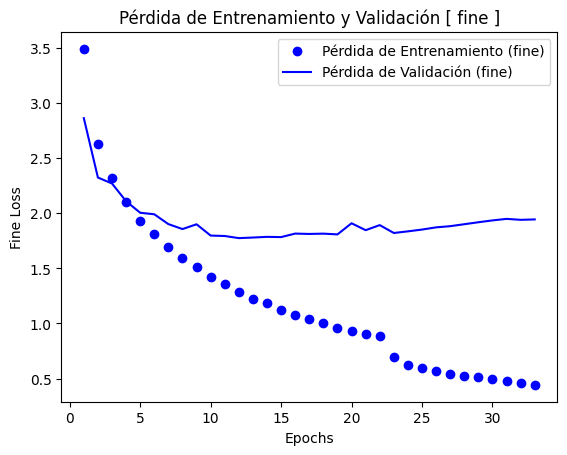

Valor máximo: 0.5817999839782715
Posición del valor máximo: 27
Valor máximo (entrenamiento): 0.8496000170707703


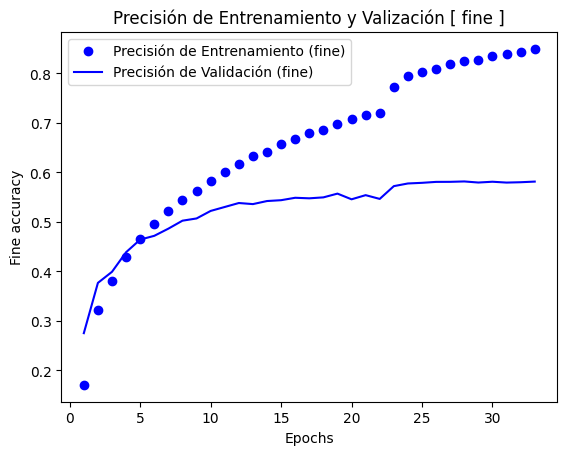

In [ ]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3))(input_layer)
batch_norm = BatchNormalization() (conv)
conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (batch_norm)
batch_norm2 = BatchNormalization(axis = 3) (conv2)
pol = MaxPooling2D(pool_size=(2, 2)) (batch_norm2)
drop = Dropout(0.3) (pol)

conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (drop)
batch_norm3 = BatchNormalization() (conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (batch_norm3)
batch_norm4 = BatchNormalization(axis = 3) (conv4)
pol2 = MaxPooling2D(pool_size=(2, 2)) (batch_norm4)
drop2 = Dropout(0.3) (pol2)

conv5 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(drop2)
batch_norm5 = BatchNormalization() (conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (batch_norm5)
batch_norm6 = BatchNormalization(axis = 3) (conv6)
pol3 = MaxPooling2D(pool_size=(2, 2)) (batch_norm6)
drop3 = Dropout(0.3) (pol3)

flat = Flatten() (pol3)

dense = Dense(512, activation='relu') (flat)

batch_norm6 = BatchNormalization() (dense)
drop4 = Dropout(0.3) (batch_norm6)

dense1 = Dense(128, activation='relu') (drop4)

output_fine = Dense(100, activation='softmax', name='output_fine') (dense1)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (dense1)

model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='Adam',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

history = model.fit(train_images_validation, {'output_fine': train_labels_fine_validation, 'output_coarse': train_labels_coarse_validation},
                      epochs = 100,
                      validation_data = ( partial_train_images_validation, {'output_fine': partial_train_labels_fine_validation, 'output_coarse': partial_train_labels_coarse_validation} ),
                      callbacks = [ model_checkpoint,
                                    early_stopping,
                                    reduce_lr ] ) # Reduce el learning si el modelo no mejora en 3 épocas.

score = model.evaluate(test_images_afiladas, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

# Graficamos la pérdida y la precisión.
history_dict = history.history
history_dict.keys()

output_fine_loss = history.history['output_fine_loss']
val_output_fine_loss = history.history['val_output_fine_loss']


epochs = range(1, len(output_fine_loss) + 1)

valor_minimo = min(val_output_fine_loss)
posicion_minimo = val_output_fine_loss.index(valor_minimo)
print("Valor mínimo:", valor_minimo)
print("Posición del valor mínimo:", posicion_minimo)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_loss, 'bo', label='Pérdida de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_loss, 'b', label='Pérdida de Validación (fine)')
plt.title('Pérdida de Entrenamiento y Validación [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine Loss')
plt.legend()

plt.show()

output_fine_accuracy = history.history['output_fine_accuracy']
val_output_fine_accuracy = history.history['val_output_fine_accuracy']

valor_maximo = max(val_output_fine_accuracy)
posicion_maximo = val_output_fine_accuracy.index(valor_maximo)
print("Valor máximo:", valor_maximo)
print("Posición del valor máximo:", posicion_maximo)

valor_maximo_entrenamiento = max(output_fine_accuracy)
posicion_maximo_entrenamiento = output_fine_accuracy.index(valor_maximo_entrenamiento)
print("Valor máximo (entrenamiento):", valor_maximo_entrenamiento)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_accuracy, 'bo', label='Precisión de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_accuracy, 'b', label='Precisión de Validación (fine)')
plt.title('Precisión de Entrenamiento y Valización [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine accuracy')
plt.legend()

plt.show()

**Precisión aproximada** = *57.16*%

Añadiendo cambios en las imagenes:
Por último, como modelo final vamos a añadir cambios en las imagenes y vamos a suprimir la segunda salida, ya que aunque se esté perdiendo parte de la información, si es modelo acierta la clase fina, va a acertar la clase gruesa.

https://www.kaggle.com/code/harshrachalwar/transformers-for-image-recognition-at-scale en este proyecto se puede ver como utilizar el data augmentation . Esto introduce variabilidad al aplicar transformaciones aleatorias, como rotaciones, escalados, recortes y cambios en la iluminación, a las imágenes originales. Esto ayuda a que el modelo se vuelva más robusto al considerar diferentes perspectivas y variaciones de los objetos en las imágenes. También se utiliza como técnica de regularización para evitar sobrentrenamiento, ya que reduce el posible sesgo.

In [49]:
# Crear el callback ReduceLROnPlateau para ajustar la tasa de aprendizaje
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_output_fine_accuracy",
                                                 factor=0.2,  # Multiplicar la tasa de aprendizaje por 0.2 (reducir en 5 veces)
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)
# Configurar el callback EarlyStopping para detener el entrenamiento si la pérdida en val_loss no mejora durante 5 épocas consecutivas
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_output_fine_accuracy",
                                                  patience=5)  # Si val_loss no disminuye durante 5 épocas consecutivas, se detiene el entrenamiento

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_output_fine_accuracy")

In [50]:
# Define el generador de imágenes con las transformaciones deseadas
datagen = ImageDataGenerator(
    rotation_range=20,  # Rango de rotación en grados
    width_shift_range=0.2,  # Rango de cambio de ancho
    height_shift_range=0.2,  # Rango de cambio de alto
    shear_range=0.2,  # Rango de deformación
    zoom_range=0.2,  # Rango de zoom
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Estrategia de relleno en caso de transformaciones
)

# Ajusta el generador a tus datos de entrenamiento
datagen.fit(train_images_validation)

In [52]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3))(input_layer)
batch_norm = BatchNormalization() (conv)
conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (batch_norm)
batch_norm2 = BatchNormalization(axis = 3) (conv2)
pol = MaxPooling2D(pool_size=(2, 2)) (batch_norm2)
drop = Dropout(0.3) (pol)

conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (drop)
batch_norm3 = BatchNormalization() (conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (batch_norm3)
batch_norm4 = BatchNormalization(axis = 3) (conv4)
pol2 = MaxPooling2D(pool_size=(2, 2)) (batch_norm4)
drop2 = Dropout(0.3) (pol2)

conv5 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(drop2)
batch_norm5 = BatchNormalization() (conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (batch_norm5)
batch_norm6 = BatchNormalization(axis = 3) (conv6)
pol3 = MaxPooling2D(pool_size=(2, 2)) (batch_norm6)
drop3 = Dropout(0.3) (pol3)

flat = Flatten() (pol3)

dense = Dense(512, activation='relu') (flat)

batch_norm6 = BatchNormalization() (dense)
drop4 = Dropout(0.3) (batch_norm6)

dense1 = Dense(128, activation='relu') (drop4)

output_fine = Dense(100, activation='softmax', name='output_fine') (dense1)

model = Model(inputs=input_layer, outputs=output_fine)

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(datagen.flow(train_images_validation, train_labels_fine_validation, batch_size=128),
                    epochs=5,
                    validation_data=(partial_train_images_validation, partial_train_labels_fine_validation))




Epoch 1/5
313/313 [==============================] - 35s 94ms/step - loss: 4.0642 - accuracy: 0.0861 - val_loss: 5.2435 - val_accuracy: 0.0246
Epoch 2/5
313/313 [==============================] - 29s 92ms/step - loss: 3.5490 - accuracy: 0.1539 - val_loss: 3.2887 - val_accuracy: 0.2064
Epoch 3/5
313/313 [==============================] - 28s 90ms/step - loss: 3.2806 - accuracy: 0.1989 - val_loss: 3.3991 - val_accuracy: 0.1918
Epoch 4/5
313/313 [==============================] - 34s 108ms/step - loss: 3.0931 - accuracy: 0.2366 - val_loss: 2.8298 - val_accuracy: 0.2820
Epoch 5/5
313/313 [==============================] - 37s 120ms/step - loss: 2.9250 - accuracy: 0.2654 - val_loss: 2.7501 - val_accuracy: 0.3070


313/313 [==============================] - 2s 5ms/step - loss: 7.8669 - accuracy: 0.0551
Precisión en el conjunto de prueba (Clasificación Fina): 0.05510000139474869
Valor mínimo: 2.7501227855682373
Posición del valor mínimo: 4


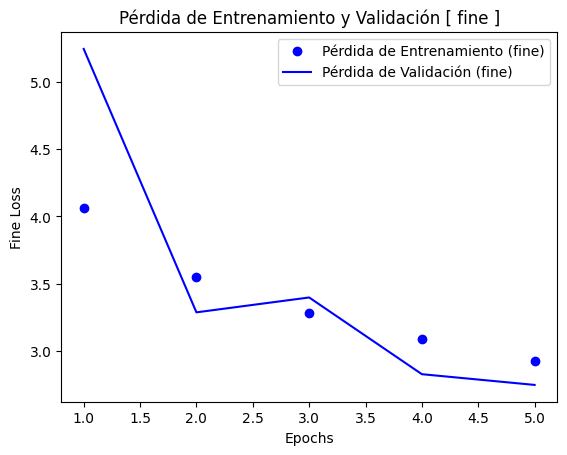

Valor máximo: 0.3070000112056732
Posición del valor máximo: 4
Valor máximo (entrenamiento): 0.2653999924659729


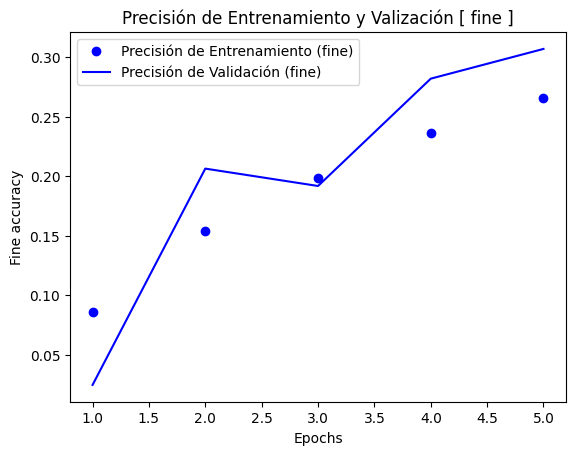

In [54]:
score = model.evaluate(test_images_afiladas, test_labels_fine)
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[1])

# Graficamos la pérdida y la precisión.
history_dict = history.history
history_dict.keys()

# Obtén las claves correctas del historial
output_fine_loss = history_dict['loss']
val_output_fine_loss = history_dict['val_loss']

epochs = range(1, len(output_fine_loss) + 1)

valor_minimo = min(val_output_fine_loss)
posicion_minimo = val_output_fine_loss.index(valor_minimo)
print("Valor mínimo:", valor_minimo)
print("Posición del valor mínimo:", posicion_minimo)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_loss, 'bo', label='Pérdida de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_loss, 'b', label='Pérdida de Validación (fine)')
plt.title('Pérdida de Entrenamiento y Validación [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine Loss')
plt.legend()

plt.show()

output_fine_accuracy = history_dict['accuracy']
val_output_fine_accuracy = history_dict['val_accuracy']

valor_maximo = max(val_output_fine_accuracy)
posicion_maximo = val_output_fine_accuracy.index(valor_maximo)
print("Valor máximo:", valor_maximo)
print("Posición del valor máximo:", posicion_maximo)

valor_maximo_entrenamiento = max(output_fine_accuracy)
posicion_maximo_entrenamiento = output_fine_accuracy.index(valor_maximo_entrenamiento)
print("Valor máximo (entrenamiento):", valor_maximo_entrenamiento)

# "bo" es para "punto azul"
plt.plot(epochs, output_fine_accuracy, 'bo', label='Precisión de Entrenamiento (fine)')
# "b" es para "linea continua azul"
plt.plot(epochs, val_output_fine_accuracy, 'b', label='Precisión de Validación (fine)')
plt.title('Precisión de Entrenamiento y Valización [ fine ]')
plt.xlabel('Epochs')
plt.ylabel('Fine accuracy')
plt.legend()

plt.show()


Observamos que el datagen es útil, pero en nuestro caso con las medidas de batch_normalization y dropout ya conseguimos evitar el sobrentrenamiento. Una vez conocemos el número de épcas, calculado anteriormente, así quedaria el modelo final:



In [11]:
input_layer = Input(shape=(32, 32, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3))(input_layer)
batch_norm = BatchNormalization() (conv)
conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (batch_norm)
batch_norm2 = BatchNormalization(axis = 3) (conv2)
pol = MaxPooling2D(pool_size=(2, 2)) (batch_norm2)
drop = Dropout(0.3) (pol)

conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (drop)
batch_norm3 = BatchNormalization() (conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (batch_norm3)
batch_norm4 = BatchNormalization(axis = 3) (conv4)
pol2 = MaxPooling2D(pool_size=(2, 2)) (batch_norm4)
drop2 = Dropout(0.3) (pol2)

conv5 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(drop2)
batch_norm5 = BatchNormalization() (conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (batch_norm5)
batch_norm6 = BatchNormalization(axis = 3) (conv6)
pol3 = MaxPooling2D(pool_size=(2, 2)) (batch_norm6)
drop3 = Dropout(0.3) (pol3)

flat = Flatten() (pol3)

dense = Dense(512, activation='relu') (flat)

batch_norm6 = BatchNormalization() (dense)
drop4 = Dropout(0.3) (batch_norm6)

dense1 = Dense(128, activation='relu') (drop4)

output_fine = Dense(100, activation='softmax', name='output_fine') (dense1)
output_coarse = Dense(20, activation='softmax', name='output_coarse') (dense1)

model = Model(inputs=input_layer, outputs=[output_fine, output_coarse])

model.compile(loss={'output_fine': 'categorical_crossentropy', 'output_coarse': 'categorical_crossentropy'},
              optimizer='Adam',
              metrics={'output_fine': 'accuracy', 'output_coarse': 'accuracy'})

model.fit(train_images_afiladas, {'output_fine': train_labels_fine, 'output_coarse': train_labels_coarse},
                      epochs = 27)

score = model.evaluate(test_images_afiladas, {'output_fine': test_labels_fine, 'output_coarse': test_labels_coarse})
print("Precisión en el conjunto de prueba (Clasificación Fina):", score[3])
print("Precisión en el conjunto de prueba (Clasificación Gruesa):", score[4])

Epoch 1/27
1563/1563 [==============================] - 35s 12ms/step - loss: 5.6594 - output_fine_loss: 3.4548 - output_coarse_loss: 2.2046 - output_fine_accuracy: 0.1762 - output_coarse_accuracy: 0.3241
Epoch 2/27
1563/1563 [==============================] - 16s 10ms/step - loss: 4.3383 - output_fine_loss: 2.6556 - output_coarse_loss: 1.6828 - output_fine_accuracy: 0.3133 - output_coarse_accuracy: 0.4719
Epoch 3/27
1563/1563 [==============================] - 16s 10ms/step - loss: 3.8108 - output_fine_loss: 2.3370 - output_coarse_loss: 1.4739 - output_fine_accuracy: 0.3804 - output_coarse_accuracy: 0.5321
Epoch 4/27
1563/1563 [==============================] - 16s 10ms/step - loss: 3.4695 - output_fine_loss: 2.1334 - output_coarse_loss: 1.3361 - output_fine_accuracy: 0.4216 - output_coarse_accuracy: 0.5741
Epoch 5/27
1563/1563 [==============================] - 17s 11ms/step - loss: 3.1926 - output_fine_loss: 1.9700 - output_coarse_loss: 1.2226 - output_fine_accuracy: 0.4583 - output

Se observa que el modelo final, con el número de épocas calculadas con la validación.
**Resultado final: 55%**

### **ANÁLISIS - CONCLUSIONES**

**Sumary:**

Hacemos un analisis del número de parametros que hay en el modelo. Habría que tener en cuenta que añadir más capas ocultas haría que el número de parametros aumente.


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 32, 32, 32)           896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 32, 32, 32)           128       ['conv2d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 32)           9248      ['batch_normalization_14

**Summary:**

Calculamos el número de parámetros:


Input_layer: no tiene parámetros entrenables, es solo la capa de entrada.


Conv2d_12: (3 x 3) tamaño filtro x 3 entradas al filtro x 32 filtros + 32 sesgo = 896


Capa Batch_normalization_14: 128


Conv2d_13: ((3 x 3) tamaño filtro x 32 entradas al filtro + 1 sesgo) x 32 filtros = 9248


Capa Batch_normalization_15: 128


Max_pooling2d_6: 0, no tiene parámetros entrenables, se encarga de filtrar.


Dropout_8: 0, tampoco tiene parámetros entrenables.


Conv2d_14: ((3 x 3) tamaño filtro x 32 entradas al filtro + 1 sesgo) x 64 filtros = 18496


Batch_normalization_16: 256


Conv2d_15:((3 x 3) tamaño filtro x 64 entradas + 1 sesgo) x 64 filtros = 36928


max_pooling2d_7: 0, no tiene parámetros entrenables, se encarga de filtrar.


dropout_9: 0, no tiene parámetros entrenables.


conv2d_16: ((3 x 3) tamaño del filtro x 64 entradas + 1 sesgo) x 128 filtros = 73856


batch_normalization_18: 256


conv2d_17: ((3 x 3) tamaño filtro x 128 entradas + 1 sesgo) x 128 filtros = 147584


batch_normalization_19: 512


max_pooling2d_8: 0, no tiene parámetros entrenables, se encarga de filtrar.


flatten_2: 0, no tiene parámetros entrenables se encarga de aplanar


dense_4:


batch_normalization_20: 2048


dropout_11:0, no tiene parámetros entrenables.


dense_5:


output_fine:


output_coarse:

Total parámetros =


**Matriz de Confusión:**

313/313 [==============================] - 1s 3ms/step


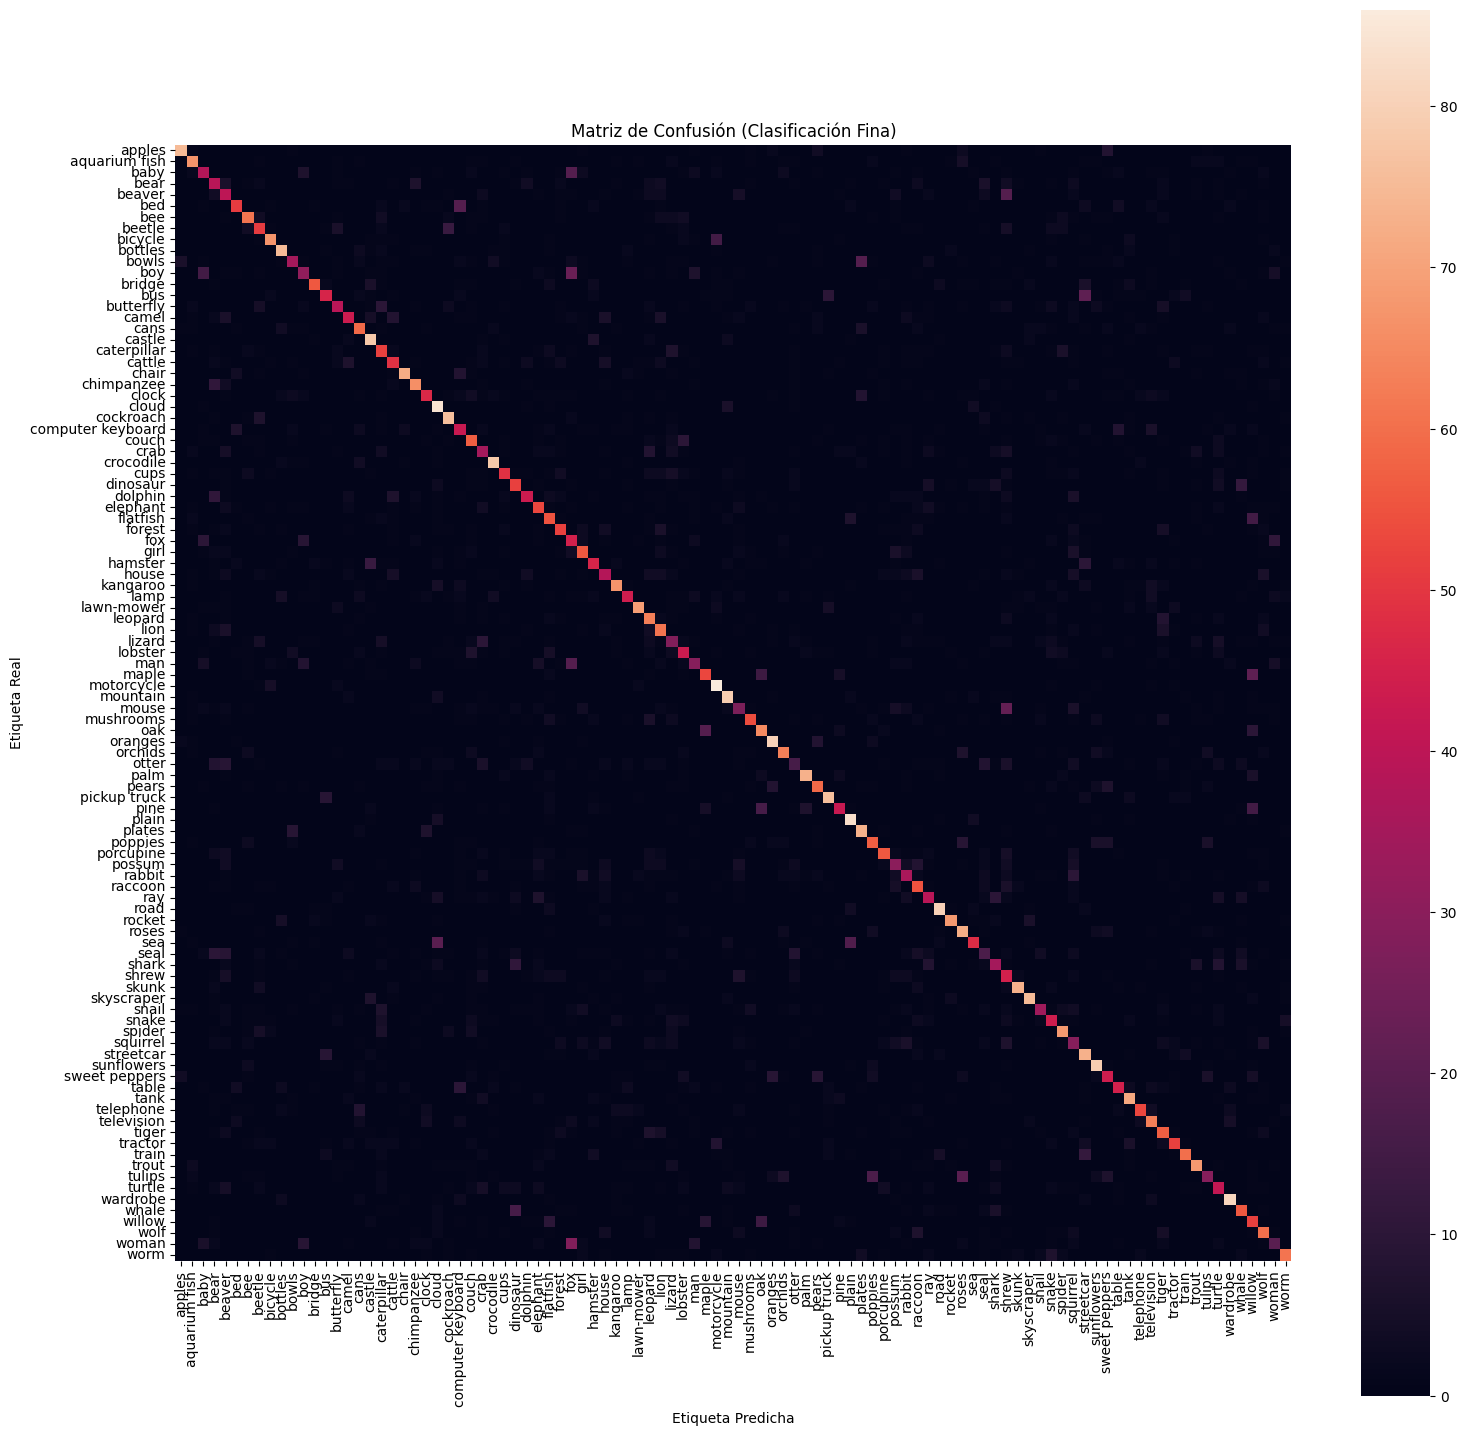

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtén las predicciones del modelo en el conjunto de prueba
predictions_fine = model.predict(test_images_afiladas)[0]

# Convierte las predicciones a clases (índices de las clases con mayor probabilidad)
predicted_classes_fine = np.argmax(predictions_fine, axis=1)

# Convierte las etiquetas reales a clases
true_classes_fine = np.argmax(test_labels_fine, axis=1)

# Obtén el nombre de las clases finas
#labels_fine = [obtener_clase(i) for i in range(100)]
labels_fine = [
    "beaver", "dolphin", "otter", "seal", "whale",
    "aquarium fish", "flatfish", "ray", "shark", "trout",
    "orchids", "poppies", "roses", "sunflowers", "tulips",
    "bottles", "bowls", "cans", "cups", "plates",
    "apples", "mushrooms", "oranges", "pears", "sweet peppers",
    "clock", "computer keyboard", "lamp", "telephone", "television",
    "bed", "chair", "couch", "table", "wardrobe",
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",
    "bear", "leopard", "lion", "tiger", "wolf",
    "bridge", "castle", "house", "road", "skyscraper",
    "cloud", "forest", "mountain", "plain", "sea",
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
    "fox", "porcupine", "possum", "raccoon", "skunk",
    "crab", "lobster", "snail", "spider", "worm",
    "baby", "boy", "girl", "man", "woman",
    "crocodile", "dinosaur", "lizard", "snake", "turtle",
    "hamster", "mouse", "rabbit", "shrew", "squirrel",
    "maple", "oak", "palm", "pine", "willow",
    "bicycle", "bus", "motorcycle", "pickup truck", "train",
    "lawn-mower", "rocket", "streetcar", "tank", "tractor"
    ]

labels_fine.sort()

# Crea la matriz de confusión
cm_fine = confusion_matrix(true_classes_fine, predicted_classes_fine)

# Visualiza la matriz de confusión usando seaborn con un colormap
plt.figure(figsize=(18, 18))
sns.heatmap(cm_fine, annot=False, cbar=True, square=True, xticklabels=labels_fine, yticklabels=labels_fine)
# sns.heatmap(cm_fine, annot=False, cbar=True, square=True)

# labels, title and ticks
plt.title("Matriz de Confusión (Clasificación Fina)")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")

plt.show()


En esta matriz de confusión se muestran las predicciones, pero al existir tantas clases es dificil comprender los resultados de cada clase. Vamos a observar algún ejemplo concreto:

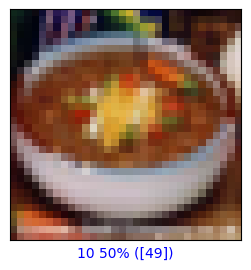

<Figure size 640x480 with 0 Axes>

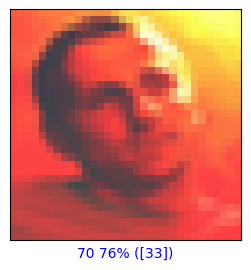

<Figure size 640x480 with 0 Axes>

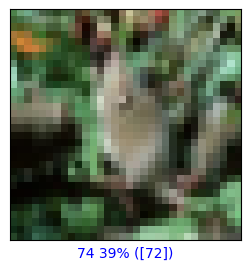

<Figure size 640x480 with 0 Axes>

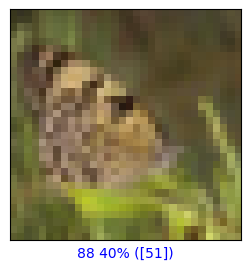

<Figure size 640x480 with 0 Axes>

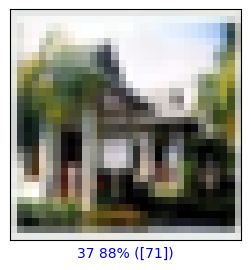

<Figure size 640x480 with 0 Axes>

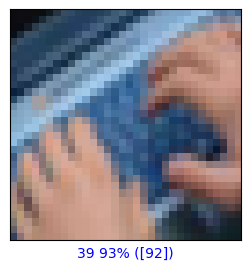

<Figure size 640x480 with 0 Axes>

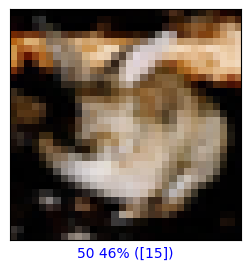

<Figure size 640x480 with 0 Axes>

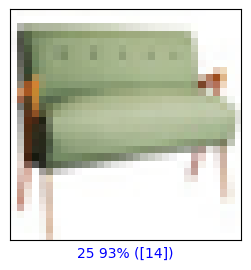

<Figure size 640x480 with 0 Axes>

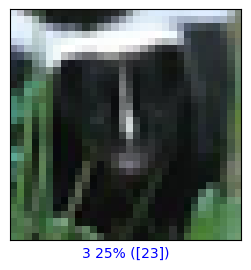

<Figure size 640x480 with 0 Axes>

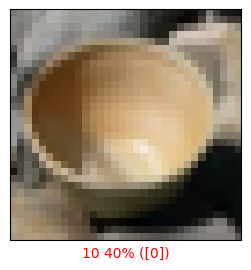

<Figure size 640x480 with 0 Axes>

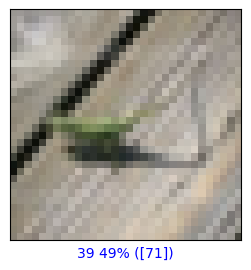

<Figure size 640x480 with 0 Axes>

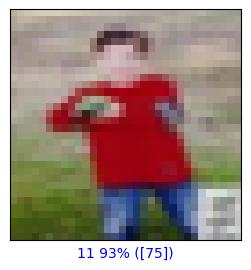

<Figure size 640x480 with 0 Axes>

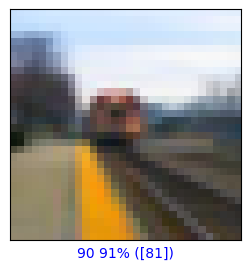

<Figure size 640x480 with 0 Axes>

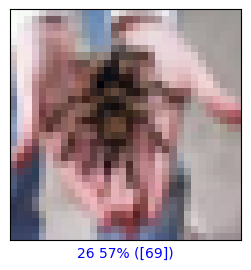

<Figure size 640x480 with 0 Axes>

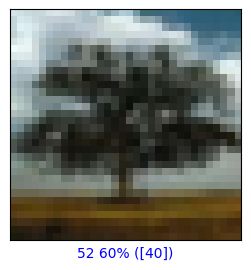

<Figure size 640x480 with 0 Axes>

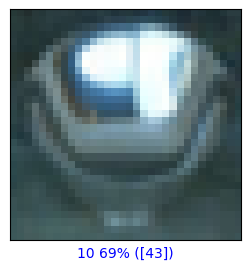

<Figure size 640x480 with 0 Axes>

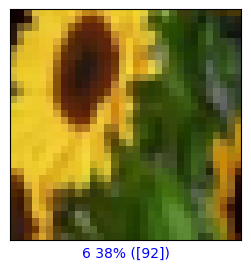

<Figure size 640x480 with 0 Axes>

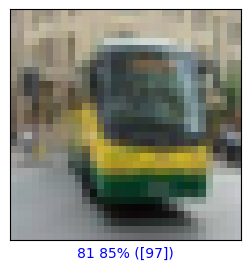

<Figure size 640x480 with 0 Axes>

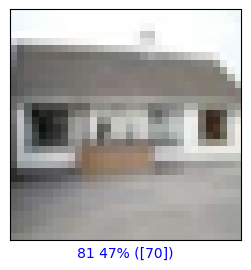

<Figure size 640x480 with 0 Axes>

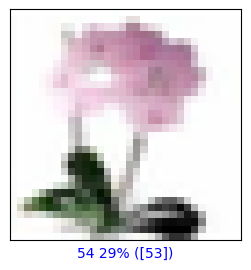

<Figure size 640x480 with 0 Axes>

In [14]:
(_, _), (_, test_labels_fine) = cifar100.load_data(label_mode='fine')
for i in range(20):
  plt.figure(figsize=(6,3))
  plot_image(i, predictions_fine[i], test_labels_fine, test_images)
  plt.show()
  plt.clf()

En este proyecto se ha abordado la mejora de la precisión mediante la exploración de técnicas de ingeniería de características, ajuste de la arquitectura del modelo y la aplicación de técnicas de regularización.

La ingeniería de características ha desempeñado un papel fundamental en la mejora de la precisión de nuestro modelo de aprendizaje automático. En particular, la aplicación de la afilación de imágenes ha demostrado ser una estrategia efectiva para resaltar características relevantes en las imágenes de nuestro conjunto de datos. Esta técnica parece haber contribuido significativamente a la capacidad del modelo para discernir patrones importantes durante el entrenamiento. Por otro lado, la aplicación del filtro de Laplace no generó mejoras sustanciales y fue descartado (aunque para otro tipo de datos podría funcionar), destacando la importancia de evaluar críticamente cada transformación aplicada. También se ha analizado una técnica para el aumento del tamaño de las imagenes. Esto habría sido muy útil si dispusiéramos de los recursos para obtener imágenes de, por ejemplo 128x128 píxeles.

La construcción de un modelo de referencia sólido fue esencial para establecer un punto de comparación durante el desarrollo del proyecto. Este modelo inicial, con una estructura simple que incluye capas convolucionales y densas, proporcionó una referencia clara para evaluar el impacto de las modificaciones introducidas durante la ingeniería de características. La comparación con este modelo de referencia permitió tomar decisiones informadas sobre qué transformaciones retener en la búsqueda de una precisión mejorada.

El modelo final que logró la mayor precisión incorporó varias estrategias efectivas. La creación de nuevas imágenes para el conjunto de datos, junto con la normalización por lotes y el uso del dropout, ha demostrado ser crucial. La generación de nuevas instancias de imágenes ayudó al modelo a diversificar su conocimiento, mientras que la normalización por lotes contribuyó a la estabilidad del entrenamiento. La implementación del dropout, una técnica de regularización, resultó fundamental para prevenir el sobreentrenamiento, permitiendo al modelo generalizar de manera más efectiva a datos no vistos.

Experimentar con la arquitectura del modelo, incluyendo el número de capas y neuronas, fue crucial para encontrar la configuración óptima que mejor se adapte a las características específicas del conjunto de datos.

Este proyecto ha proporcionado una base para futuras investigaciones y refinamientos sobre las redes convolucionales.